<a href="https://colab.research.google.com/github/merveenoyan/smol-vision/blob/main/inference_gists/IBM_Granite_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multimodal Granite 3.1 2B

IBM released Granite-Vision-3.1-2B preview, a compact Llava-like vision language model based on Granite Instruct 3.1 for text backbone and SigLIP for image backbone.

It has very impressive [scores on different benchmarks](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview#granite-vision-31-2b-preview) for it's size for vision understanding and document understanding.

It comes with transformers and vLLM integration from the start too! Let's put it to test.

In [ ]:
!pip install -q pdf2image git+https://github.com/huggingface/transformers.git
!sudo apt-get install -q poppler-utils

## Document Understanding

We'd like to ask Granite Vision to explain a chart in a given document, and perhaps ask further questions.

In [2]:
!wget -q https://www.europarl.europa.eu/pdfs/news/expert/2018/7/story/20180706STO07407/20180706STO07407_en.pdf

In [3]:
from pdf2image import convert_from_path
import os

pdf_path = "20180706STO07407_en.pdf"
images = convert_from_path(pdf_path)

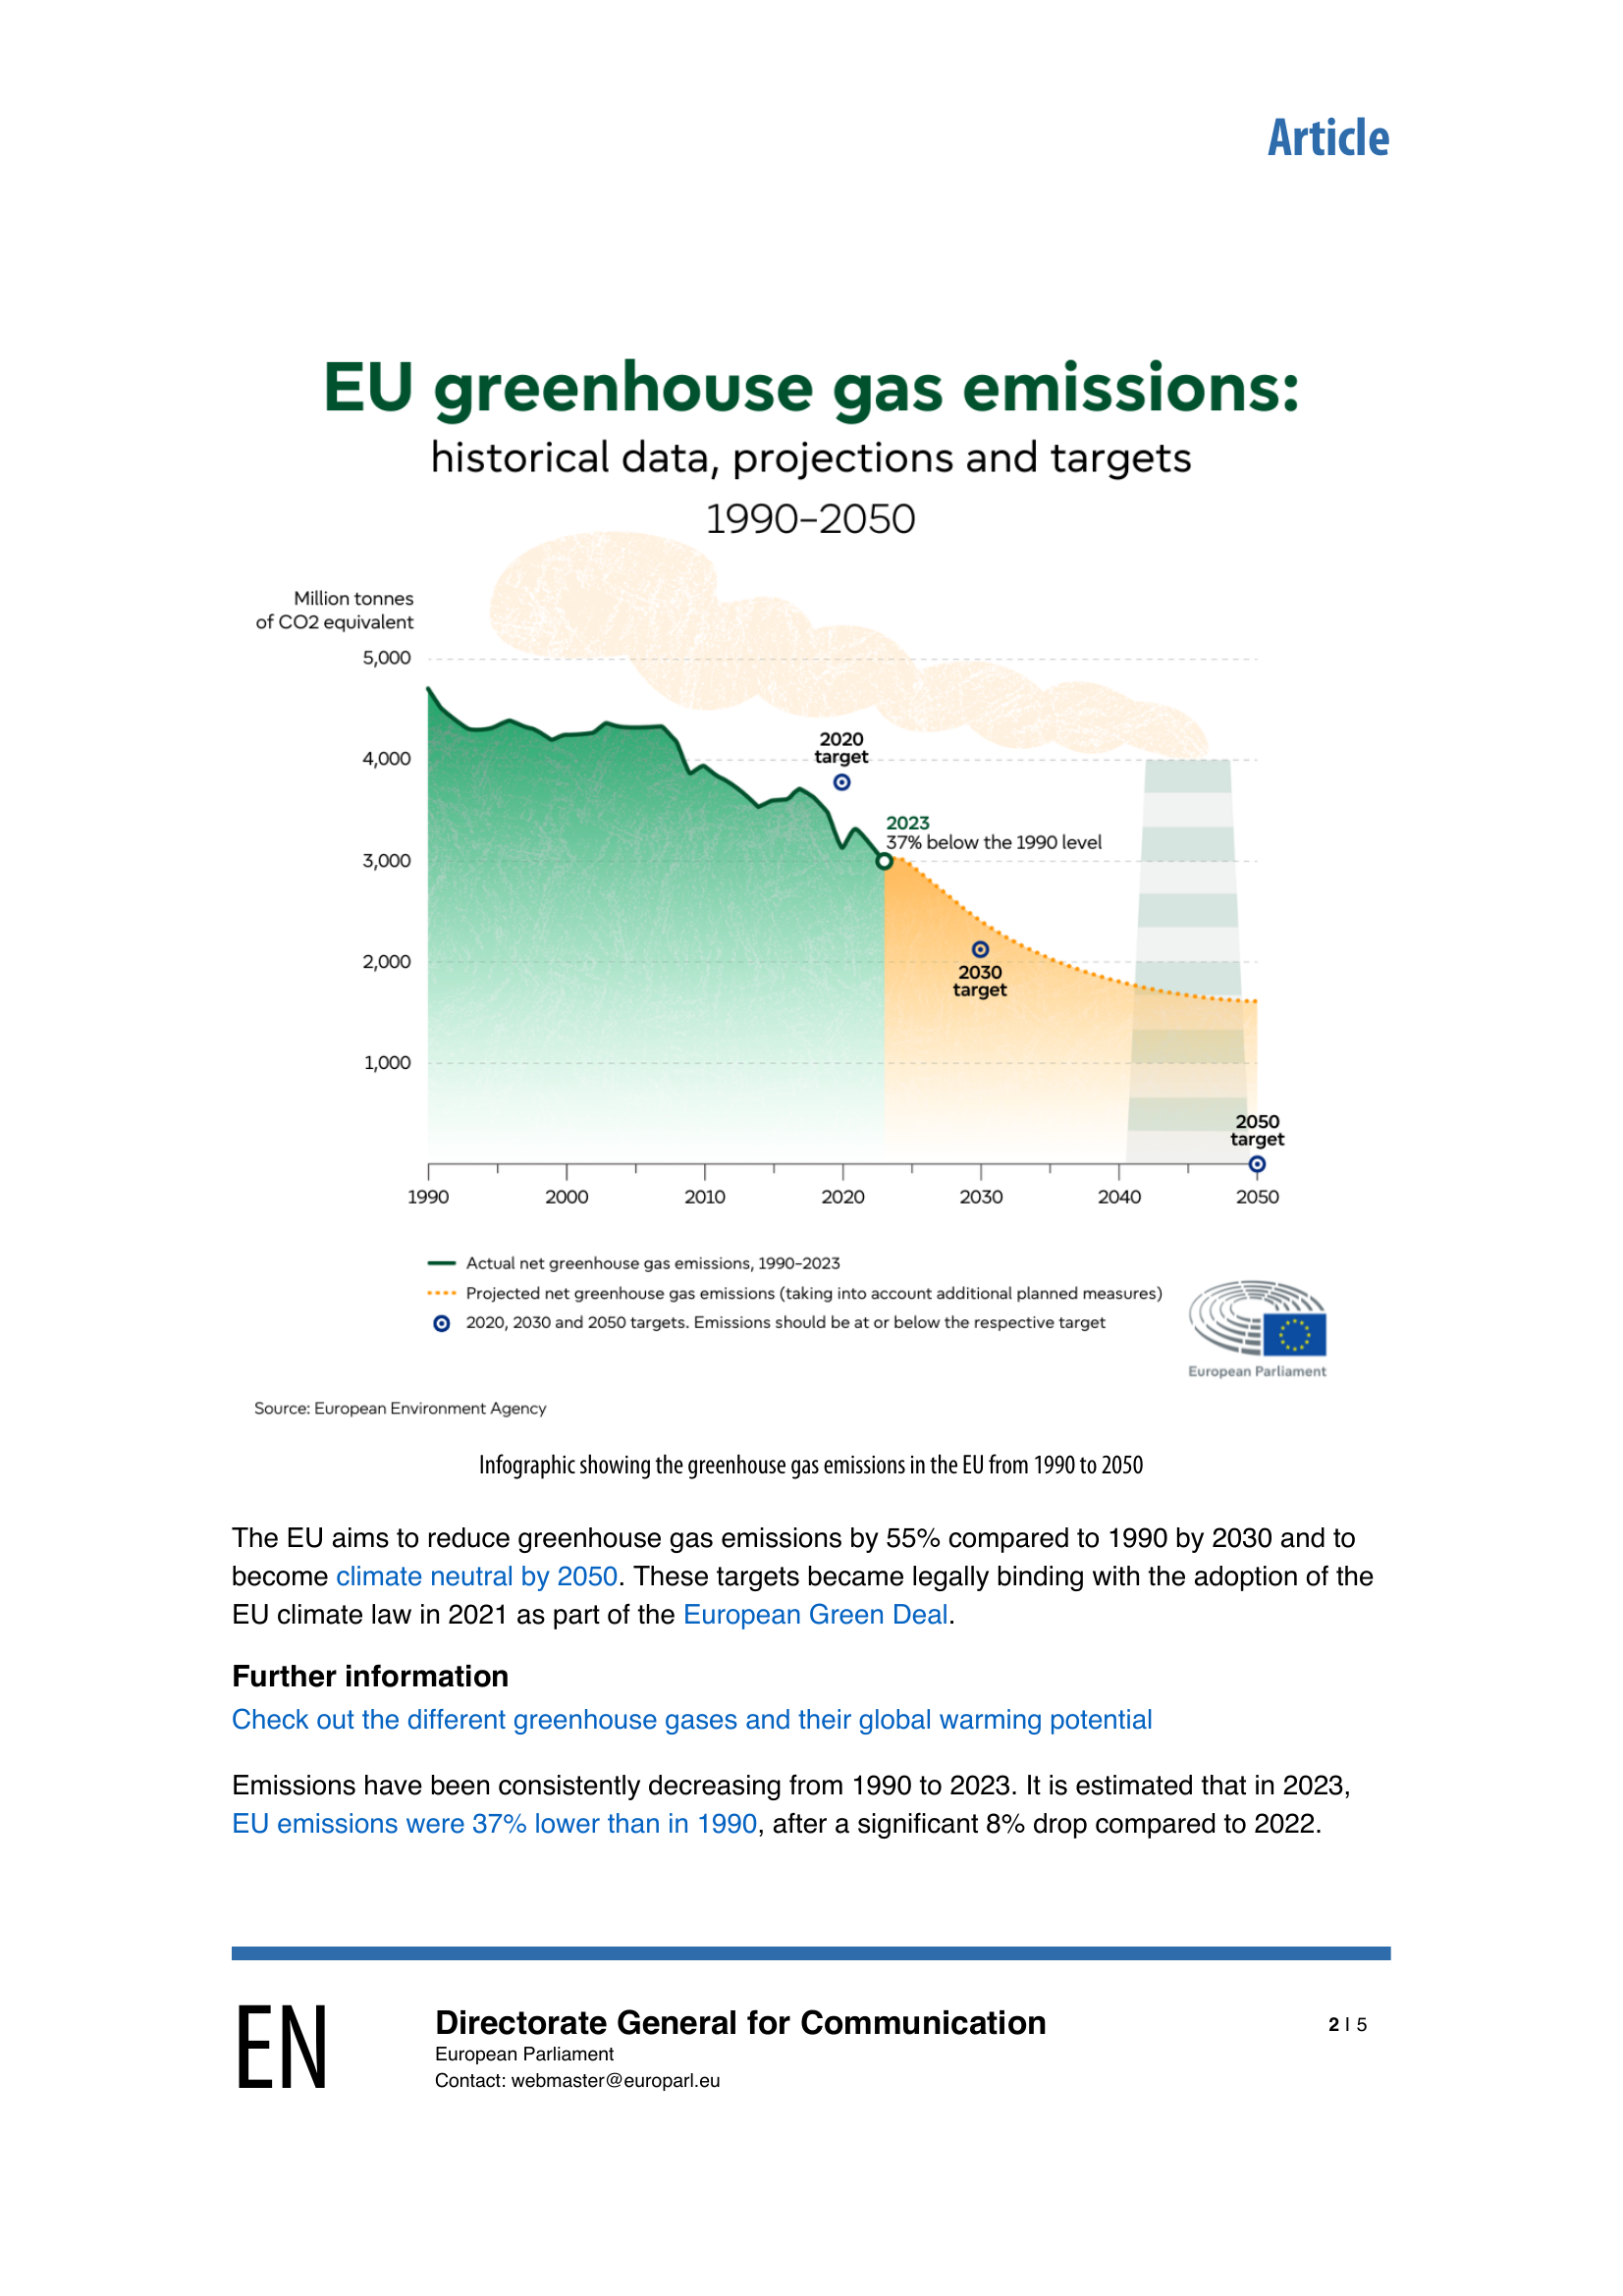

In [4]:
images[1]

We can use `LlavaNextForConditionalGeneration` class to load Granite Vision and infer.

In [5]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

model_path = "ibm-granite/granite-vision-3.1-2b-preview"
processor = LlavaNextProcessor.from_pretrained(model_path)
model = LlavaNextForConditionalGeneration.from_pretrained(model_path, device_map="cuda:0")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/1.99k [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/6.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.10k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/86.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

We will use chat template to format our image and text input together, then pass it to the model.

In [6]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": images[1]},
            {"type": "text", "text": "Explain the chart in the image in detail."},
        ],
    },
]
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda:0")


# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=500)
print(processor.decode(output[0], skip_special_tokens=True))


<|user|>

Explain the chart in the image in detail.
<|assistant|>
The image is a detailed infographic titled "EU greenhouse gas emissions: historical data, projections and targets." It provides a visual representation of greenhouse gas emissions in the European Union from 1990 to 2050. The infographic is divided into three main sections:

1. **Historical Data (1990-2023):**
   - The section shows a line graph that illustrates the trend of greenhouse gas emissions over the years.
   - The graph starts at a baseline in 1990, with emissions rising to a peak around 2000.
   - After 2000, there is a noticeable decline in emissions, with a significant drop in the following years.
   - By 2023, the emissions are projected to be significantly lower than in 1990.

2. **Projected Data (2023-2050):**
   - The section includes a line graph that projects the trend of greenhouse gas emissions from 2023 to 2050.
   - The projections show a continued decline in emissions, with a more pronounced decrea

Correct answer and quite high quality generation.

## Paper Understanding

The authors report various benchmarks, one that caught my eye was LiveXiv which is about ArXiv paper understanding. Let's put it to test.

In [7]:
!wget -q https://arxiv.org/pdf/2405.04324

In [8]:
pdf_path = "/content/2405.04324"
images = convert_from_path(pdf_path)

We'll test understanding from a page of Granite Code paper of IBM.

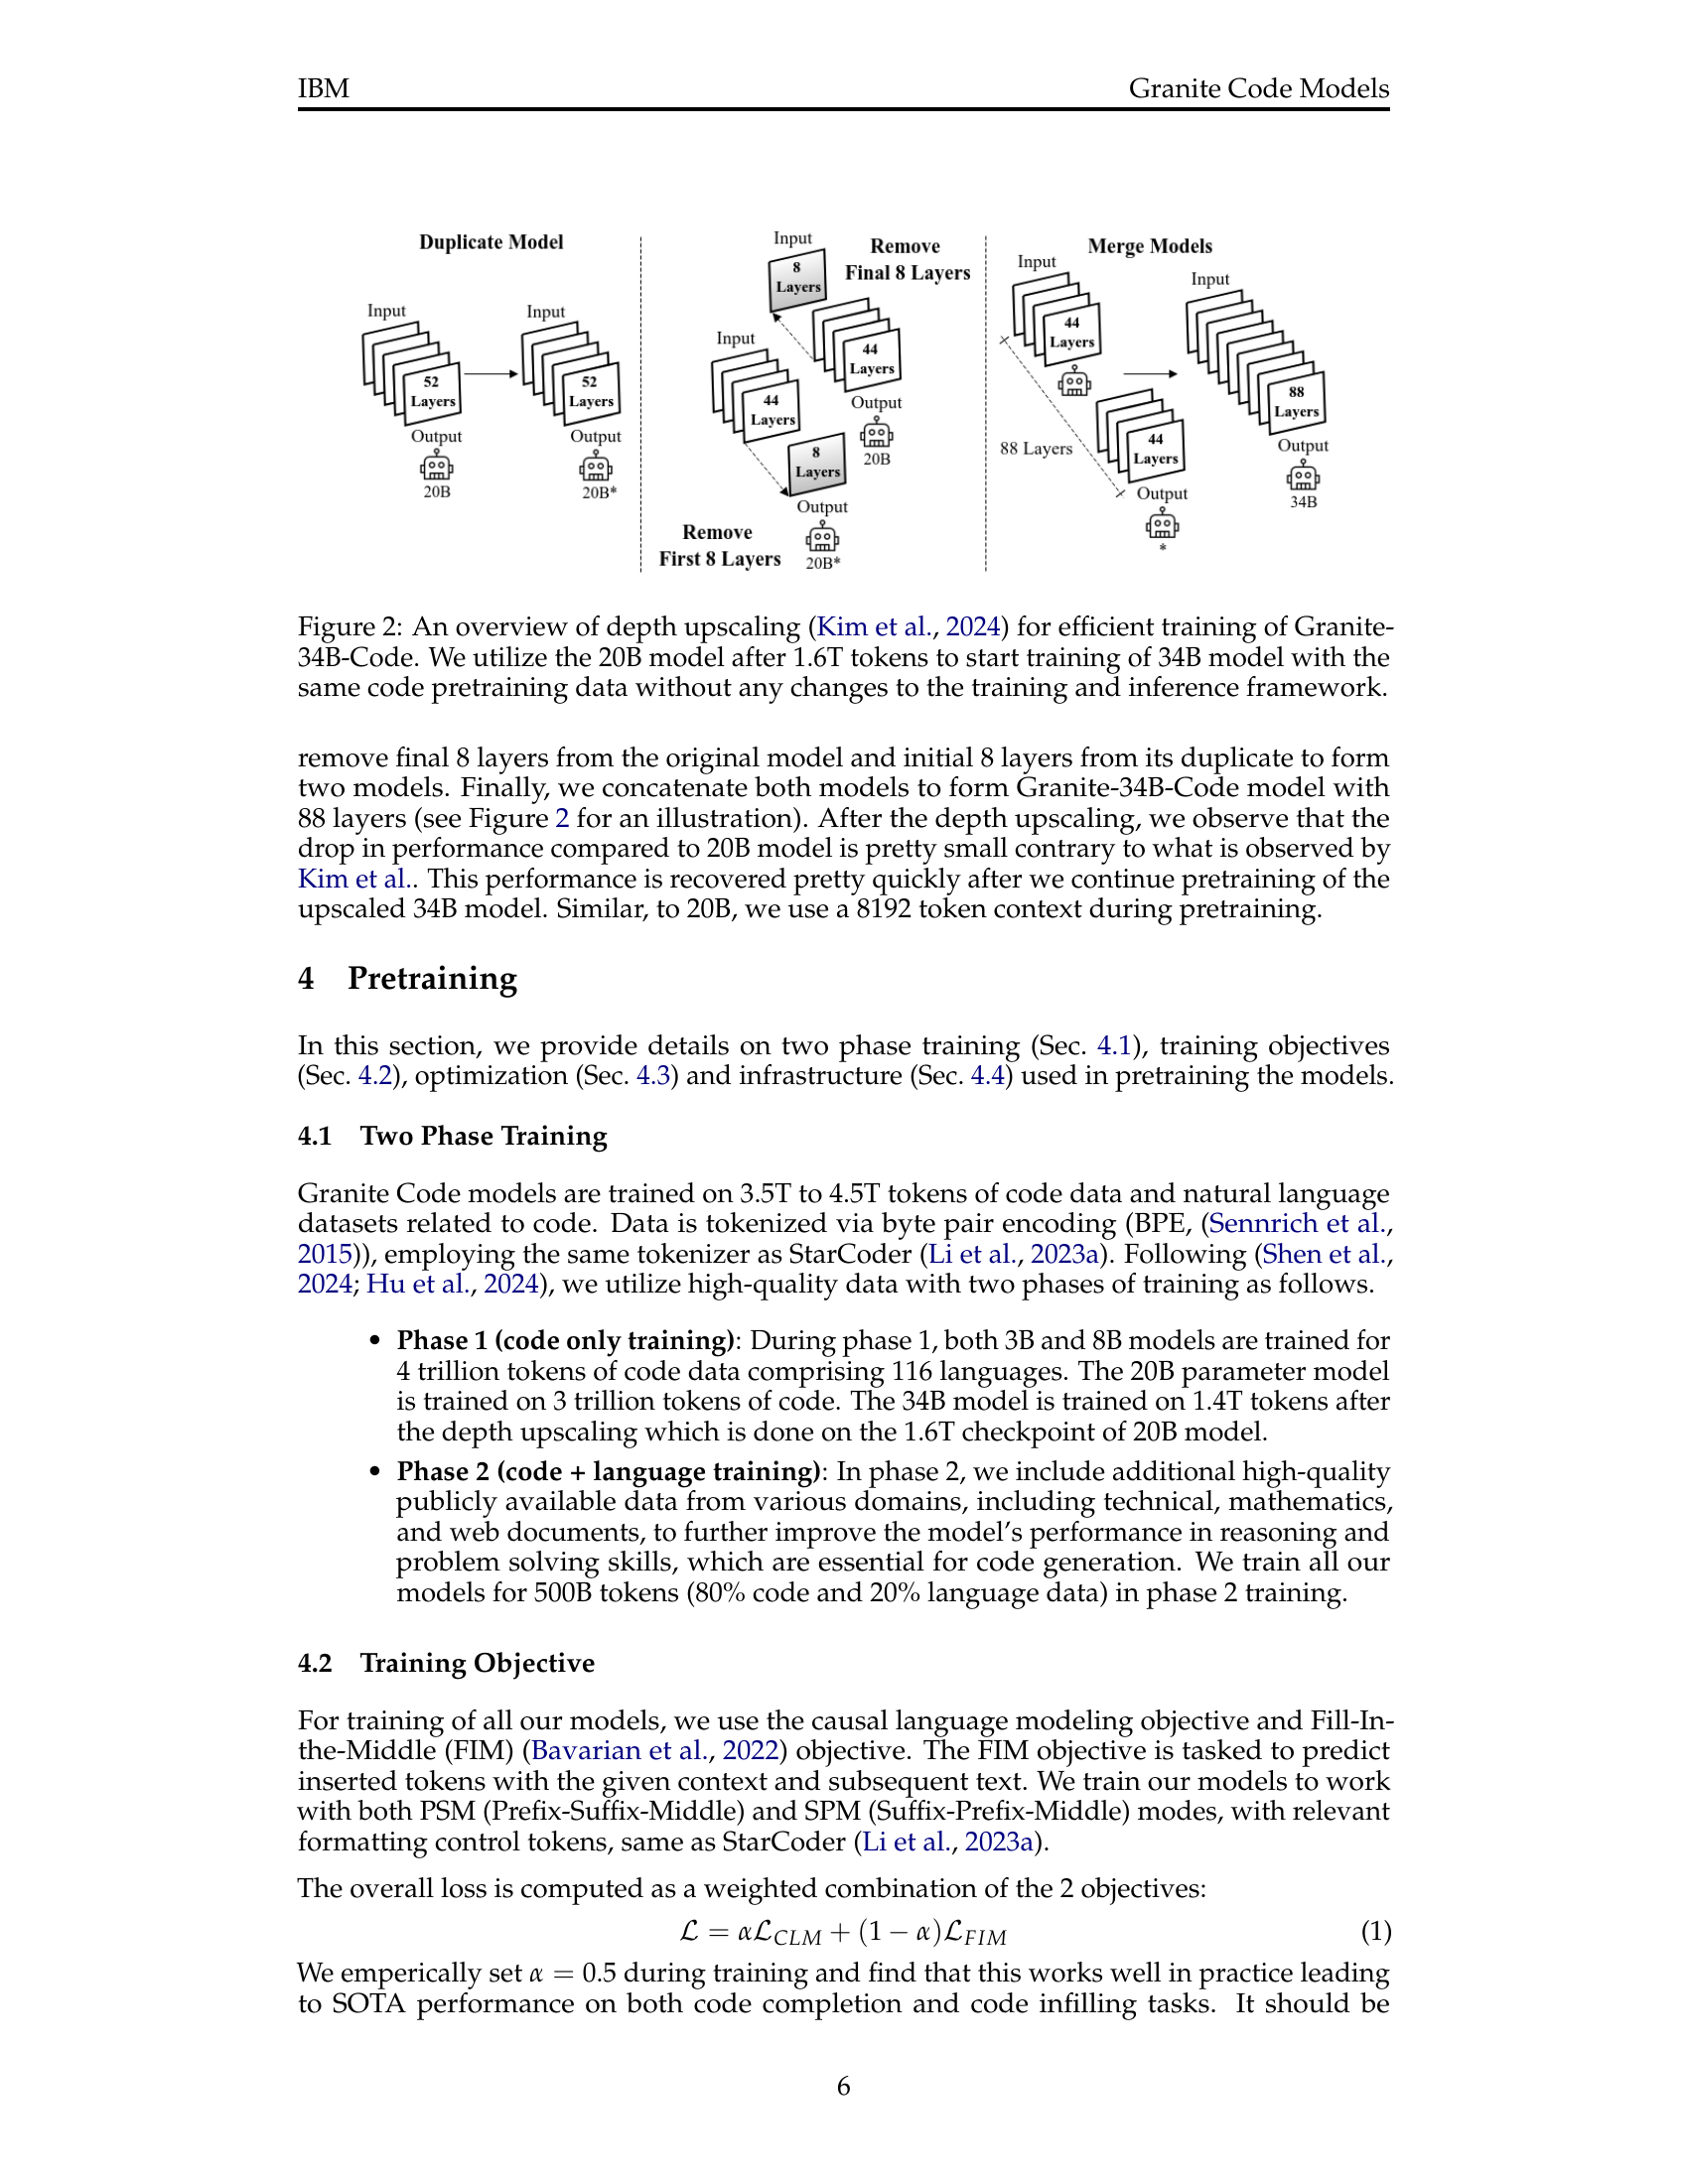

In [9]:
images[5]

In [10]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": images[5]},
            {"type": "text", "text": "What differences does this paper contribute to model architecture and training?"},
        ],
    },
]
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda:0")


# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=500)
print(processor.decode(output[0], skip_special_tokens=True))


<|user|>

What differences does this paper contribute to model architecture and training?
<|assistant|>
This paper contributes to model architecture by proposing a method for efficient training of Granite34B-Code. It introduces a depth upscaling technique that allows for the use of a 20B model as a starting point for training a 34B model with the same code pretraining data. This approach avoids changes to the training and inference framework, enhancing the model's adaptability and performance.


The answer is correct!

## Read More

Get more info about the model from [the model repository](https://huggingface.co/ibm-granite/granite-vision-3.1-2b-preview), including benchmarks, how to get started with transformers and vLLM.